# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

$$ yhat = g(x,w) $$
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

$$ f(w) = \sum_i (y_i - g(x_i,w))^2 $$
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

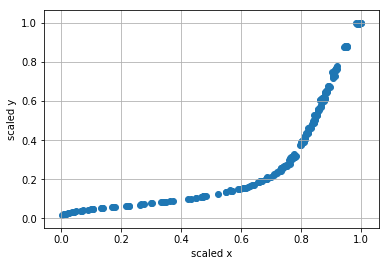

In [3]:
# TODO
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)

#plt.plot(x,y)
#plt.show()
plt.scatter(x,y)
plt.xlabel('scaled x')
plt.ylabel('scaled y')
plt.grid(True)
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

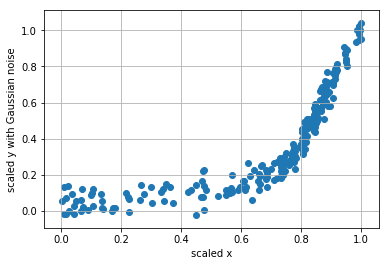

In [4]:
# TODO
yn = y + np.random.normal(loc=0.0, scale=0.05, size=len(y))

plt.scatter(x, yn)
plt.xlabel('scaled x')
plt.ylabel('scaled y with Gaussian noise')
plt.grid(True)
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33, random_state=12)

print(xtr.shape, ytr.shape)

(158,) (158,)


## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[:d+1]
    b = w[-d:]
    
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    ar = a[::-1]
    br = np.append(b[::-1],1)
    yhat = np.array([np.polyval(ar,xi)/np.polyval(br,xi) for xi in x])
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

# TODO.  Create the transformed feature matrix
xd = np.array([[xi**j for j in range(1,d+1)] for xi in xtr])
yd = np.repeat(ytr, d).reshape((len(ytr), d))
Z = np.append(xd, xd*yd, axis=1)

regr = LinearRegression()
regr.fit(Z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit

ws = np.append(regr.coef_[:d], -1*regr.coef_[-d:])
winit = np.insert(ws, 0, regr.intercept_)

print(winit)

[ 0.05730521 -0.32951876  0.32175918 -0.01450093 -6.16321688  9.74674249
 -4.5607597 ]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

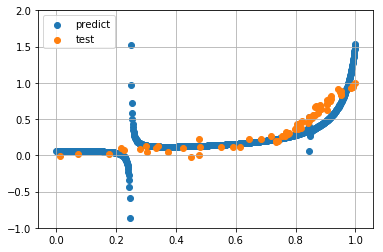

In [8]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp)

plt.scatter(xp, yhat)
plt.scatter(xts, yts)
plt.legend(['predict','test'])
plt.ylim(-1,2)
plt.grid()
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

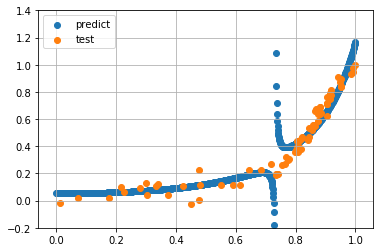

In [9]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(Z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
ws = np.append(regr.coef_[:d], -1*regr.coef_[-d:])
winit = np.insert(ws, 0, regr.intercept_)

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat = predict(winit, xp)

plt.scatter(xp, yhat)
plt.scatter(xts, yts)
plt.ylim(-0.2,1.4)
plt.legend(['predict','test'])
plt.grid()
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

$$ f(w) = 0.5*\sum_i (y[i] - yhat[i])^2 $$
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
        
    
    # TODO.  Parse w
    d = (len(w)-1)//2
    a = w[:d+1] # (a0, a1, ... ad)
    b = w[-d:] #(b0, b1, ... b{d-1})

    # TODO.  Znum[i,j] = x[i]**j
    Znum = np.array([[xi**j for j in range(d+1)] for xi in x])
    # TODO.  Zden[i,j] = x[i]**(j+1)
    Zden = np.array([[xi**(j+1) for j in range(d)] for xi in x])
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    numerators = Znum.dot(a)
    denominators = Zden.dot(b)+1
    yhat = numerators/denominators
    #print([(y[i], yhat[i]) for i in range(len(y))])
    # TODO.  Compute loss
    f = 0.5*np.sum((y-yhat)**2)
    
    # TODO.  Compute gradients
    fga = np.dot(np.array([Znum[i]/denominators[i] for i in range(len(y))]).T, yhat-y)
    fgb = np.dot(np.array([Zden[i]/denominators[i] for i in range(len(y))]).T, yhat*(y-yhat))

    fgrad = np.append(fga, fgb)
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
w0 = winit
f0, fgrad0 = feval(w0, xtr, ytr)

step = 1e-6
w1 = w0 + step
f1, fgrad1 = feval(w1, xtr, ytr)

df_est = fgrad0.dot(w1-w0)

print("Actual f1-f0    = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)

Actual f1-f0    =   5.1874e-02
Predicted f1-f0 =   5.1395e-02


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

In [12]:
# TODO
nit = 10000
step = 1e-6
w0 = winit

fgd = []

for it in range(nit):
    f0, fgrad0 = feval(w0, xtr, ytr)
    w0 = w0 - step*fgrad0
    fgd.append(f0)

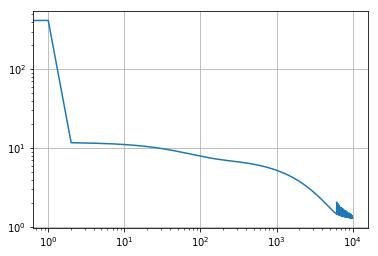

In [13]:
t = np.arange(nit)
plt.loglog(t, fgd)
plt.grid(True)

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

In [14]:
# TODO
fadapt = []
nit = 10000
w0 = winit
step = 1e-6  # Initial step
alpha=0.5

for it in range(nit):
    f0, fgrad0 = feval(w0, xtr, ytr)
    w1 = w0 - step*fgrad0
    
    f1, fgrad1 = feval(w1, xtr, ytr)
    df_est = sum(fgrad0**2)
    
    if (f1-f0 < alpha*step*df_est) and (f1<f0):
        step = step * 2
        fgrad0 = fgrad1
        w0 = w1
    else:
        step = step/2
    fadapt.append(f0)
    

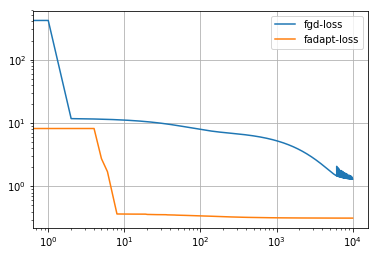

In [15]:
t = np.arange(nit)
plt.loglog(t, fgd)
plt.loglog(t, fadapt)
plt.legend(['fgd-loss','fadapt-loss'])
plt.grid(True)

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

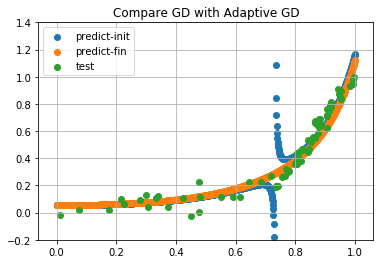

In [16]:
# TODO
xp = np.linspace(0,1,1000)
yhat_init = predict(winit, xp)
yhat_fin = predict(w0, xp)

plt.scatter(xp, yhat_init)
plt.scatter(xp, yhat_fin)
plt.scatter(xts, yts)
plt.ylim(-0.2,1.4)
plt.legend(['predict-init','predict-fin','test'])
plt.title('Compare GD with Adaptive GD')
plt.grid()
plt.show()

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

In [17]:
# TODO
nit = 10000
step = 1e-6
beta = 0.99
w0 = winit
_, z=feval(w0, xtr, ytr)

fmgd = []

for it in range(nit):
    f0, fgrad0 = feval(w0, xtr, ytr)
    z = beta*z+fgrad0
    w0 = w0 - step*z
    fmgd.append(f0)

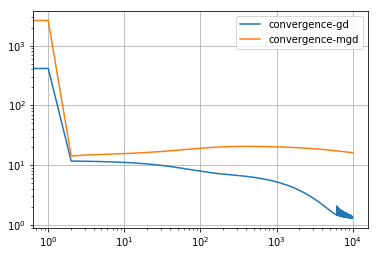

In [18]:
t = np.arange(nit)
plt.loglog(t, fgd)
plt.loglog(t, fmgd)
plt.legend(['convergence-gd', 'convergence-mgd'])
plt.grid(True)

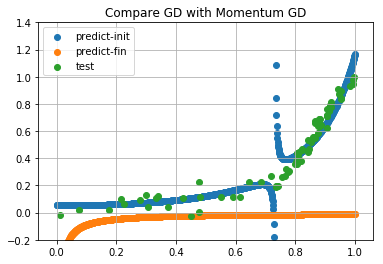

In [19]:
# TODO
# plot yhat vs. x
xp = np.linspace(0,1,1000)
yhat_init = predict(winit, xp)
yhat_fin = predict(w0, xp)

plt.scatter(xp, yhat_init)
plt.scatter(xp, yhat_fin)
plt.scatter(xts, yts)
plt.ylim(-0.2,1.4)
plt.legend(['predict-init','predict-fin','test'])
plt.grid()
plt.title('Compare GD with Momentum GD')
plt.show()

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.